In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow import keras


from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import class_weight

from itertools import cycle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Layer, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization,
    GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Multiply, Concatenate, LeakyReLU
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.saving import register_keras_serializable


2025-01-24 23:53:07.247673: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-24 23:53:07.430477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737791587.490794   81758 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737791587.507650   81758 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 23:53:07.653417: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Cancer Detection

Detect cancer in patches of images taken from much larger scans. 

## Introduction

The data set itself is a set of pathology samples for us to classify as either Malignant, or Benign. A Malignant label is given if a 32x32 square at the center of each image has at least 1 pixel of cancer tissue.

## Data Exploration

The original data set did include a lot of duplicates. However, the Kaggle dataset we have doesn't.

### Data Layout

The data itself is laid out into the `data/` directory like so

    data/
    ├── histopathologic-cancer-detection.zip
    ├── sample_submission.csv
    ├── test
    ├── train
    └── train_labels.csv

We are expected to create our own `submission.csv` based on the contents of the `test/` directory.

Let's first load the training data meta info.

In [2]:
labels = pd.read_csv("data/train_labels.csv")

# Display the first few rows of the labels dataframe
print(labels.head())

# Basic statistics about the dataset
print(labels['label'].value_counts())
print(labels['label'].value_counts(normalize=True))

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
label
0    130908
1     89117
Name: count, dtype: int64
label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


Let's examine the data in test as well.

    $ find data/test/ -type f | wc -l
    57458

We will be testing data about 26% the size of the training data, an acceptable ratio.

Furthermore, to validate the data, we can use the `file` command to see if the data is valid or not. The file command reports each file with something like this:

    data/train/00086774164e0e8f4b1f1ec9d21c82dce6d62b02.tif: 
        TIFF image data, 
        little-endian, 
        direntries=15, 
        height=96, 
        bps=194, 
        compression=none, 
        PhotometricIntepretation=RGB, 
        description={"shape": [96, 96, 3]}, 
        width=96


### Unbalanced Classes

As you can see from the below plot, the distribution of cases is not balanced. Any classiier will have a bias towards Benign cases. There are techniques that we can use to get around this issue, which we will discuss further.

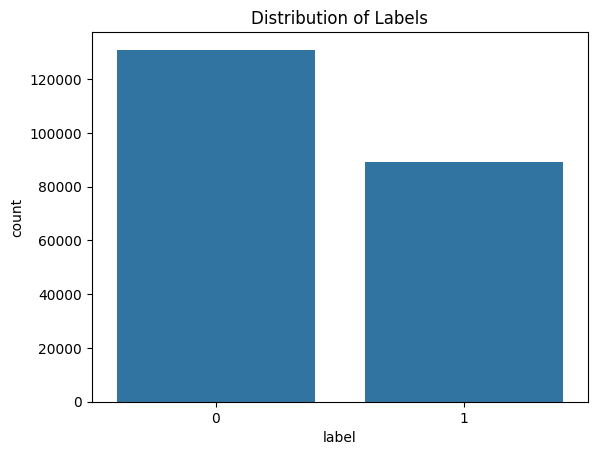

In [3]:
sns.countplot(data=labels, x='label')
plt.title("Distribution of Labels")
plt.show()

### Image Stats

With this image stats, we can look for saturated pixel intensities. THis will help us identify bad samples that are mostly one color or not.

In [4]:
def calculate_image_stats(image_ids):
    stats = []
    for img_id in image_ids:
        img = np.array(Image.open(os.path.join("data/train", f"{img_id}.tif")))
        stats.append((img.mean(), img.std()))
    return pd.DataFrame(stats, columns=['Mean Intensity', 'Std Dev Intensity'])

# Calculate stats for a random sample of images
sampled_ids = labels.sample(100, random_state=42)['id'].values
image_stats = calculate_image_stats(sampled_ids)

print(image_stats.describe())

       Mean Intensity  Std Dev Intensity
count      100.000000         100.000000
mean       168.634027          49.753331
std         41.551068          14.902584
min         45.370334           1.406036
25%        139.026901          43.449624
50%        172.700883          51.199801
75%        196.274604          59.362743
max        250.932581          77.487390


From these numbers, we can see that some a really high in tensity with the max being 250. A 25% percentile of images have an intensity of 196 or higher. This could mean that some images are very intense in color and may be saturating some images.


Visualizing images with label 0:


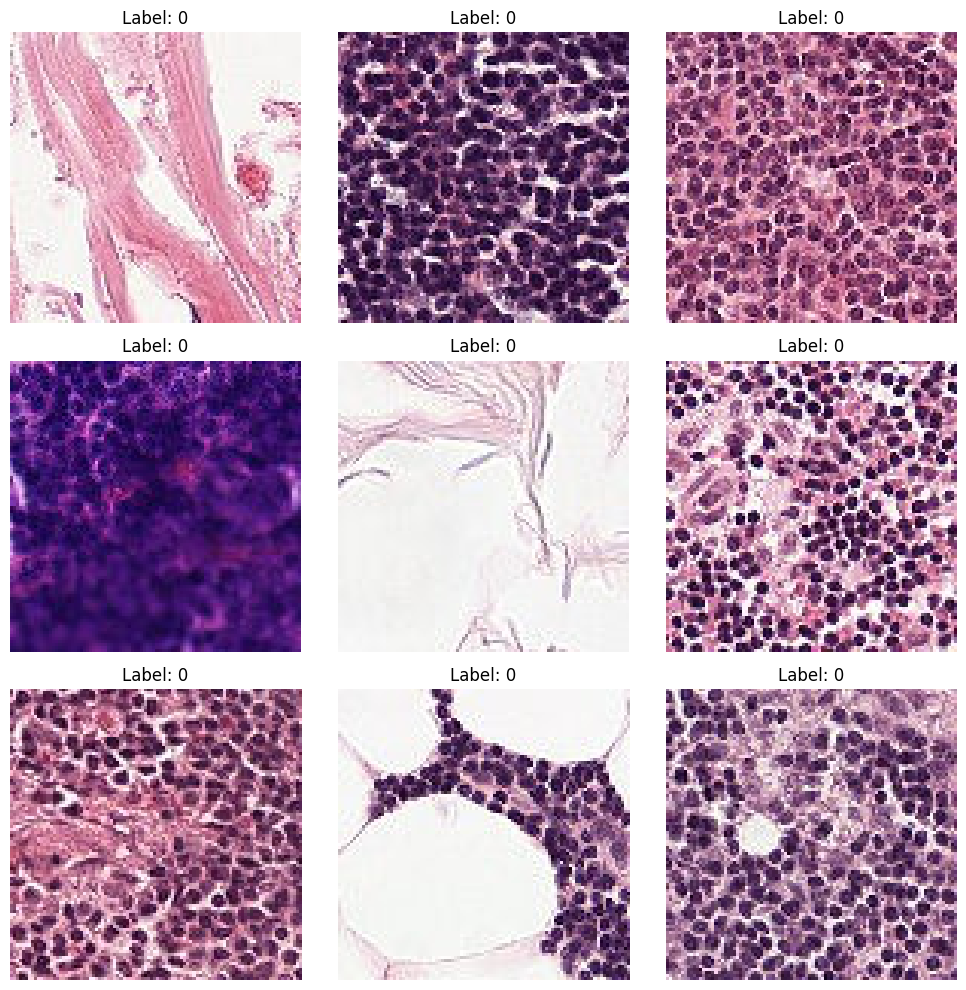

Visualizing images with label 1:


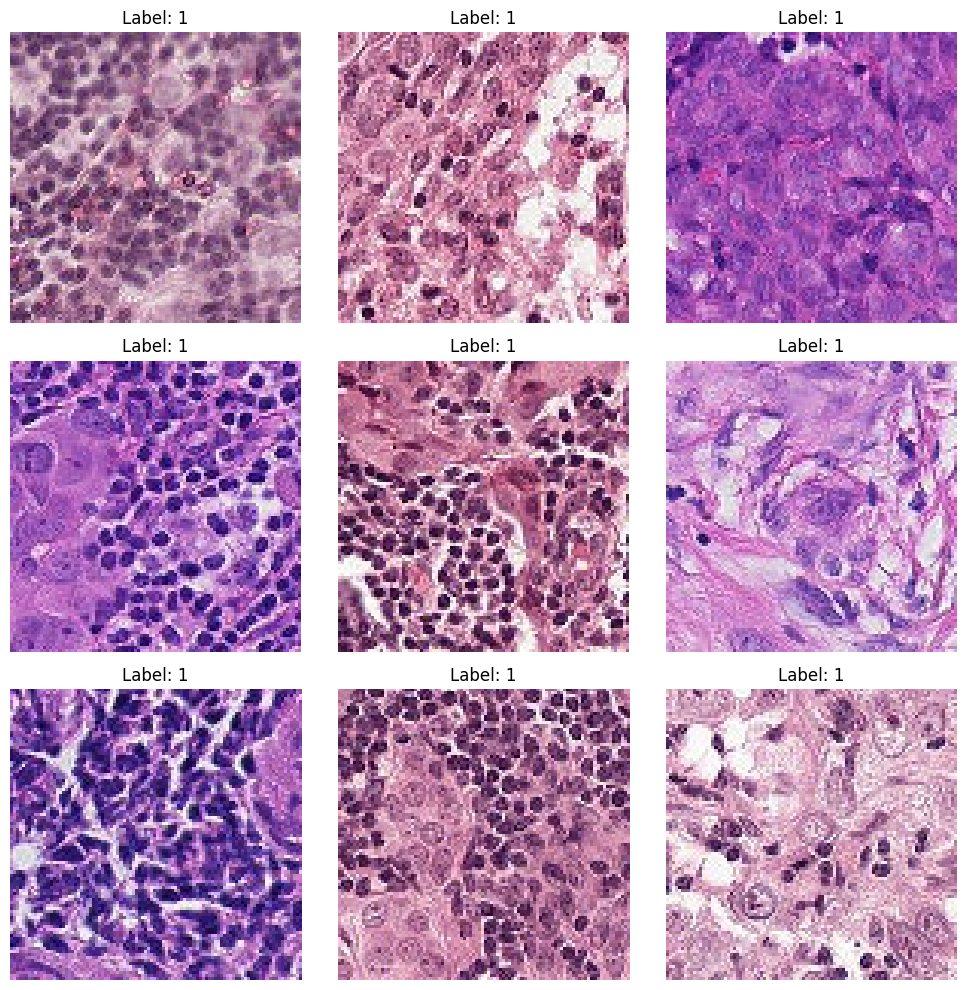

In [5]:
# Define a function to plot a grid of images
def plot_images(image_ids, labels, nrows=3, ncols=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        if i < len(image_ids):
            img = Image.open(os.path.join("data/train", f"{image_ids[i]}.tif"))
            ax.imshow(img)
            ax.set_title(f"Label: {labels[i]}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Sample images from each class
sampled_0 = labels[labels['label'] == 0].sample(9, random_state=42)
sampled_1 = labels[labels['label'] == 1].sample(9, random_state=42)

print("Visualizing images with label 0:")
plot_images(sampled_0['id'].values, sampled_0['label'].values)

print("Visualizing images with label 1:")
plot_images(sampled_1['id'].values, sampled_1['label'].values)

### Data Cleaning

There are 3 major things to do for data cleaning.
1. Distribution of labels
2. file path needed
3. Filter image based on image intensity


#### Filtered Image

Based on the above results of the plot of images and image stats, we can see some images are almost completely blank. We can try and remove those images if the are 5% or less of any non-white color.

#### File Path

This can be as simple as re-populating the 'id' column wiht the path to the correct tif file.

#### Unbalanced classes

First thing is first: the data is biased in favor of one class over the other, let's balance the data.

we have a few options. we could under sample the majority class, bringing them to the same count. Or we can over sample the minority class. More data is good, so let's over sample.[1]

Since there is only the image id and label, that's all the data we can work with. This doesn't give us any indication to more thane one kind of 'positive' label.

1 - https://arxiv.org/abs/1106.1813

In [6]:
# Paths to data
train_images = 'data/train/'
label_csv = 'data/train_labels.csv'

# Read labels
full_df = pd.read_csv(label_csv)
full_df['id'] = full_df['id'] + '.tif'
full_df['label'] = full_df['label'].astype(str)

# Filtering function
def filter_images(image_dir, image_ids, black_thresh=0.95, white_thresh=0.95):
    valid_ids = []
    
    for img_id in image_ids:
        img_path = os.path.join(image_dir, img_id)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            continue  # Skip unreadable images
        
        # Normalize pixel values to [0, 1]
        img = img / 255.0
        
        # Calculate black and white pixel ratios
        black_ratio = np.sum(img < 0.1) / img.size
        white_ratio = np.sum(img > 0.9) / img.size
        
        # Keep images that are NOT mostly black or white
        if black_ratio < black_thresh and white_ratio < white_thresh:
            valid_ids.append(img_id)
    
    return valid_ids

# Filter the images
valid_image_ids = filter_images(train_images, full_df['id'].tolist())
print(f"Number of valid images: {len(valid_image_ids)}")

# Update full_df to include only valid images
filtered_df = full_df[full_df['id'].isin(valid_image_ids)].reset_index(drop=True)
print(f"Updated dataframe shape: {filtered_df.shape}")



Number of valid images: 218749
Updated dataframe shape: (218749, 2)


#### Unbalanced Classes

Here we will fix up the unbalacned classes by oversampling the minority class. Then we concat the two frames and shuffle to complete balancing.

Before rebalancing
label
0    129658
1     89091
Name: count, dtype: int64

After rebalancing
label
1    129658
0    129658
Name: count, dtype: int64


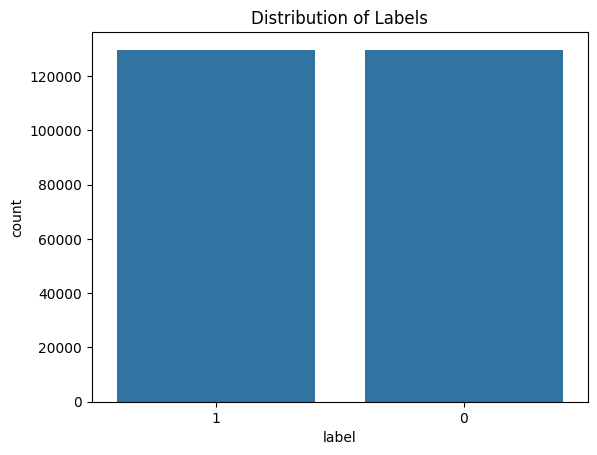

In [7]:
print("Before rebalancing")
print(filtered_df['label'].value_counts())
# print(filtered_df.head())

class_0 = filtered_df[filtered_df['label'].astype(int) == 0]
class_1 = filtered_df[filtered_df['label'].astype(int) == 1]

# Oversample the minority class
class_1_oversampled = class_1.sample(len(class_0), replace=True, random_state=42)
# print(class_1_oversampled['label'].value_counts())
# Combine the classes into a balanced dataset
balanced_labels = pd.concat([class_0, class_1_oversampled])

# Shuffle the dataset
balanced_labels = balanced_labels.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nAfter rebalancing")
print(balanced_labels['label'].value_counts())
# print(balanced_labels.head())

# Show the newly balanced labels
sns.countplot(data=balanced_labels, x='label')
plt.title("Distribution of Labels")
plt.show()

# balanced_labels = labels
# filtered_df = balanced_labels

In [8]:
# Split the data into train_df and valid_df with stratified sampling
train_df, valid_df = train_test_split(
    balanced_labels, 
    test_size=0.2,               # 20% for validation
    stratify=balanced_labels['label'],     # Stratify by the label column to preserve proportions
    random_state=42              # Set random seed for reproducibility
)

# Display the size of each dataset to confirm the split
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")

Training set size: 207452
Validation set size: 51864


### Data Engineering, Loading, and Transformation

explain what a ImageDataGenerator an flow() is 

Typically, most computer vision tricks will move, rotate, or other wise transform an image for training. This is a way to synthesize more data from the limited set we do have. Here, we have options to shift, crop, squeeze or rotate the image for training.

In [9]:
# Set batch size
BATCH_SIZE = 32

# Combined data generator with augmentations
train_datagen = ImageDataGenerator(
    rescale=1/255,                # Normalize pixel values to [0, 1]
    rotation_range=15,            # Rotate images by up to 15 degrees
    width_shift_range=0.4,        # Horizontal shift (up to 40%)
    height_shift_range=0.4,       # Vertical shift (up to 40%)
    horizontal_flip=True,         # Flip images horizontally
    zoom_range=0.2,               # Zoom in/out slightly
    fill_mode='reflect'           # Fill mode to handle shifts (options: 'nearest', 'constant', 'reflect', 'wrap')
)

# Flow the entire training dataframe
train_loader = train_datagen.flow_from_dataframe(
    dataframe=train_df,           # Full training dataframe
    directory=train_images,       # Directory with images
    x_col='id',                   # Column with image filenames
    y_col='label',                # Column with labels (0 or 1)
    class_mode='binary',          # Binary classification
    target_size=(96, 96),         # Resize images to 96x96
    batch_size=BATCH_SIZE,        # Batch size
    shuffle=True                  # Shuffle images during training
)

# Validation data generator (no augmentations)
valid_datagen = ImageDataGenerator(rescale=1/255)

valid_loader = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,           # Validation dataframe
    directory=train_images,       # Directory with images
    x_col='id',
    y_col='label',
    class_mode='binary',
    target_size=(96, 96),
    batch_size=BATCH_SIZE,
    shuffle=False                 # No shuffling for validation
)

Found 207452 validated image filenames belonging to 2 classes.
Found 51864 validated image filenames belonging to 2 classes.


## Model Plan

We plan on reusing ImageNet's feature extraction to help us with this task. We will use AUC and validation AUC as a training metric. FInally, we evaluate with confusion matrices.

### Metrics
Here we talk about making our life easier with some helper code.

since we're doing a classification task, let's use AUC.

Talk about confusion matrix

### Model Experimentation

the train function we made will compile an object and then fit it with the training data.

we then take the model and make a confusion matrix to show how well we did.

In [10]:
# Plot the training and validation accuracy and loss curves
def plot_training_curves(history):
    # Get training and validation metrics
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(auc))
    
    plt.figure(figsize=(12, 6))

    # Plot AUC
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, auc, label='Training AUC')
    plt.plot(epochs_range, val_auc, label='Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend(loc='lower right')
    plt.title('Training and Validation AUC')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()


def train_and_perf_report(model, train_loader, valid_loader, learning_rate = 0.0001, cutoff=0.50):
    early_stop = EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, verbose=1)
    model_checkpoint = ModelCheckpoint("frozen_layers_13_imagenet_model.keras", save_best_only=True, monitor="val_auc")
    
    # Specify the number of steps per epoch for the train dataframe
    steps_per_epoch = len(train_loader)  # Single generator for train dataframe
    
    
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, 
                loss='binary_crossentropy', 
                metrics=[AUC(name='auc')]) 
    
    
    # Train the model
    history = model.fit(
        train_loader,                
        validation_data=valid_loader,     
        epochs=30,
        callbacks=[early_stop, lr_scheduler, model_checkpoint],
        verbose=1
    )
    
    # Call the function to display the curves
    plot_training_curves(history)
    
    # Define class names for labels
    class_names = ["Benign", "Malignant"]
    
    # Get true labels from validation set
    y_true = valid_loader.labels  # True labels from validation generator
    
    # Predict probabilities for the validation set
    y_pred_prob = model.predict(valid_loader)  # Predicted probabilities
    
    # Convert probabilities to binary class predictions
    y_pred = (y_pred_prob > cutoff).astype(int).flatten()  # Binary classification threshold
    
    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Display the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True)
    
    plt.title("Confusion Matrix")
    plt.show()
    
    # Generate the precision-recall report
    print("Classification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)

#     history = cnn_model.fit(
#         train_generator,
#         validation_data=val_generator,
#         epochs=10,
#         steps_per_epoch=len(train_generator),
#         validation_steps=len(val_generator)
#     )

### Transfer Learning

I was intruiged by the idea of transfer learning. Stealing is great.

Transfer learning is re-using another neural network model but trained on my own data. We will use Imagenet, a very powerful, robust image classifier. 

This is easy to do with Keras. We can use the `EfficientNetB0` objject with the imagenet weights loaded up. We first run through the layers, marking them as frozen or not depending if they are numbered less than the experiment. We then add a custom classification head to get us to the two labels. There is a Dropout Layer added to prevent overfitting, and to act as regularization.

Why should we use Transfer Learning? We don't have a lot of images to work with, especially compared to ImageNet's training set. By leveraging the huge amount of data for ImageNet, we can tack on our own training layers and data to extract features using the more powerful neural network.

we suppose the lower levels in imagenet will be useful. afterall, we are looking at shapes, colors, and gradients, not traffic signs or complex objects. so we guess we should grab the lower layers by percentage. 6, 13, 25, and 37 layers correspond to roughly 2.5%, 5%, 10%, and 15% of imagenet's original layers

## The Experiments

To find the right layer, we have to experiment with different number of frozen layers. We are guessing the lower layers will be more useful. Imagenet has 237 layers normally.

Here we have experiments for the 6, 13, 25, and 37 layer networks.

We also have an optimization for optimal cutoff that we will try

Next, will get rid of the Dropout layer from some of our models to see if we truly need it.

Finally, let's see if rotating the images is a good idea or not with a custom ImageProcessor.

In [12]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

def frozen_layers_imagenet(frozen_layer=25, **kwargs):
    # Load the EfficientNetB0 base model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
    
    # Freeze the first 100 layers
    for layer in base_model.layers[:frozen_layer]:
        layer.trainable = False
    
    # Unfreeze the remaining layers
    for layer in base_model.layers[frozen_layer:]:
        layer.trainable = True
    
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    # Combine the base model with the classification head
    model = Model(inputs=base_model.input, outputs=output)
    
    # Compile the model with a low learning rate for fine-tuning
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model
    # history = model.fit(train_generator, validation_data=val_generator, epochs=10)
    # return model, history
    return model

# Declare these so we don't violate the DRY principl.e
def frozen_layers_13_imagenet(**kwargs):
    return frozen_layers_imagenet(frozen_layer=13)

def frozen_layers_6_imagenet(**kwargs):
    return frozen_layers_imagenet(frozen_layer=6)

def frozen_layers_25_imagenet(**kwargs):
    return frozen_layers_imagenet(frozen_layer=25)

def frozen_layers_37_imagenet(**kwargs):
    return frozen_layers_imagenet(frozen_layer=37)


### The Experiment Runs

Here we see each experiment. First, the various frozen layers are used.

I0000 00:00:1737690542.817180  271273 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10172 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/30


/home/user/School/boulder/intro_to_deep_learning/week3/.env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1737690554.738392  271904 service.cc:148] XLA service 0x78f990002ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737690554.748749  271904 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-01-23 19:49:15.175118: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737690556.896610  271904 cuda_dnn.cc:529] Loaded cuDNN version 90300
2

   5/6483 ━━━━━━━━━━━━━━━━━━━━ 3:24 32ms/step - auc: 0.5485 - loss: 0.7279 

I0000 00:00:1737690570.981880  271904 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2469/6483 ━━━━━━━━━━━━━━━━━━━━ 2:07 32ms/step - auc: 0.8580 - loss: 0.4631

2025-01-23 19:50:52.428017: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19478', 16 bytes spill stores, 16 bytes spill loads

2025-01-23 19:50:52.584867: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19478_0', 344 bytes spill stores, 520 bytes spill loads

2025-01-23 19:50:52.660330: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21425', 24 bytes spill stores, 28 bytes spill loads

2025-01-23 19:50:52.742785: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21425', 24 bytes spill stores, 24 bytes spill loads

2025-01-23 19:50:52.761015: I external/local_xla/xla

6483/6483 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.8937 - loss: 0.4036

2025-01-23 19:53:28.758845: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2060', 16 bytes spill stores, 16 bytes spill loads

2025-01-23 19:53:28.846737: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2060_0', 344 bytes spill stores, 520 bytes spill loads

2025-01-23 19:53:28.847471: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2060', 104 bytes spill stores, 104 bytes spill loads



6483/6483 ━━━━━━━━━━━━━━━━━━━━ 267s 37ms/step - auc: 0.8937 - loss: 0.4036 - val_auc: 0.9705 - val_loss: 0.2285 - learning_rate: 1.0000e-04
Epoch 2/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 220s 34ms/step - auc: 0.9572 - loss: 0.2616 - val_auc: 0.9783 - val_loss: 0.2115 - learning_rate: 1.0000e-04
Epoch 3/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 220s 34ms/step - auc: 0.9682 - loss: 0.2243 - val_auc: 0.9793 - val_loss: 0.2527 - learning_rate: 1.0000e-04
Epoch 4/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 221s 34ms/step - auc: 0.9741 - loss: 0.2011 - val_auc: 0.9692 - val_loss: 0.3319 - learning_rate: 1.0000e-04
Epoch 5/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 220s 34ms/step - auc: 0.9783 - loss: 0.1840 - val_auc: 0.9823 - val_loss: 0.1867 - learning_rate: 1.0000e-04
Epoch 6/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 219s 34ms/step - auc: 0.9810 - loss: 0.1718 - val_auc: 0.9839 - val_loss: 0.1656 - learning_rate: 1.0000e-04
Epoch 7/30
6482/6483 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.9827 - loss: 0.1631
Epoch 7: ReduceLROnPl

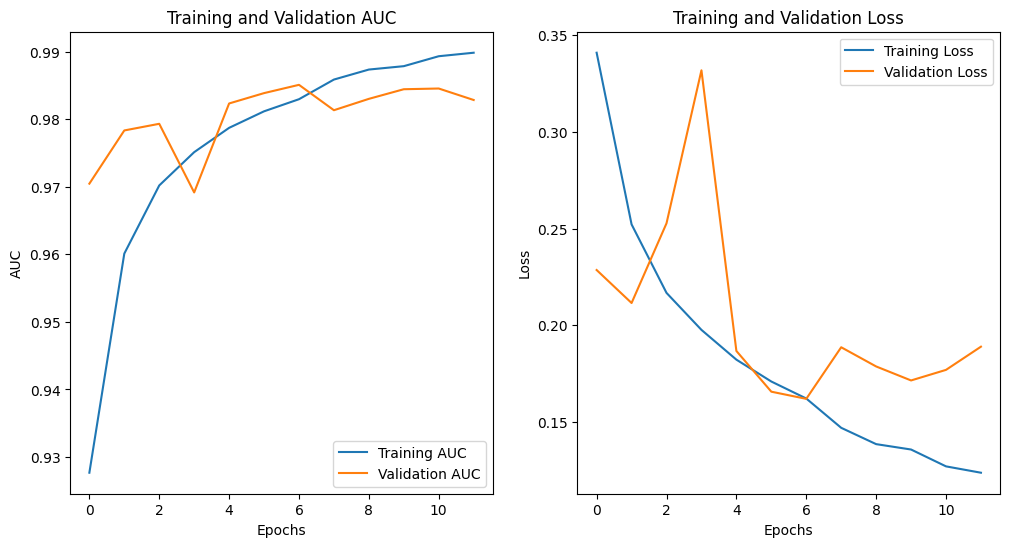

1621/1621 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step


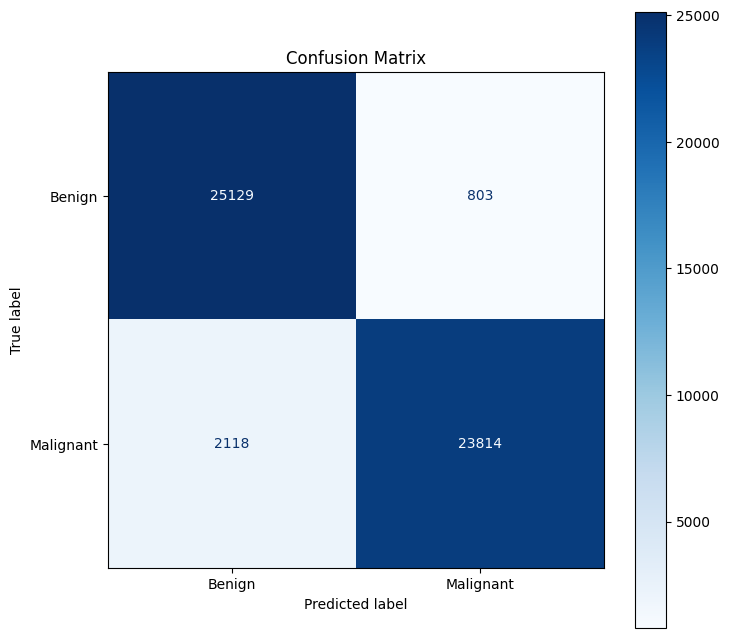

Classification Report:
              precision    recall  f1-score   support

      Benign       0.92      0.97      0.95     25932
   Malignant       0.97      0.92      0.94     25932

    accuracy                           0.94     51864
   macro avg       0.94      0.94      0.94     51864
weighted avg       0.94      0.94      0.94     51864



In [12]:
frozen_layers_6_imagenet_model = frozen_layers_6_imagenet()
train_and_perf_report(frozen_layers_6_imagenet_model, train_loader, valid_loader, learning_rate = 0.0001, cutoff=0.50)

I0000 00:00:1737760312.571881    7510 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10172 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/30


/home/user/School/boulder/intro_to_deep_learning/week3/.env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1737760323.581763    7704 service.cc:148] XLA service 0x7008fc003ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737760323.592008    7704 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-01-24 15:12:03.984550: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737760325.576028    7704 cuda_dnn.cc:529] Loaded cuDNN version 90300
2

   5/6483 ━━━━━━━━━━━━━━━━━━━━ 3:03 28ms/step - auc: 0.5298 - loss: 0.7140 

I0000 00:00:1737760338.334941    7704 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3279/6483 ━━━━━━━━━━━━━━━━━━━━ 1:37 30ms/step - auc: 0.8502 - loss: 0.4759

2025-01-24 15:14:01.018605: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18585', 16 bytes spill stores, 16 bytes spill loads

2025-01-24 15:14:01.109149: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18585_0', 344 bytes spill stores, 520 bytes spill loads

2025-01-24 15:14:01.171132: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20412', 24 bytes spill stores, 24 bytes spill loads

2025-01-24 15:14:01.214548: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20412', 32 bytes spill stores, 32 bytes spill loads

2025-01-24 15:14:01.239511: I external/local_xla/xla

6482/6483 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.8733 - loss: 0.4409

2025-01-24 15:16:05.074356: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2060', 16 bytes spill stores, 16 bytes spill loads

2025-01-24 15:16:05.221250: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2060_0', 344 bytes spill stores, 520 bytes spill loads

2025-01-24 15:16:05.274920: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2060', 104 bytes spill stores, 104 bytes spill loads



6483/6483 ━━━━━━━━━━━━━━━━━━━━ 254s 35ms/step - auc: 0.8733 - loss: 0.4409 - val_auc: 0.8240 - val_loss: 0.6692 - learning_rate: 1.0000e-04
Epoch 2/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 211s 33ms/step - auc: 0.9387 - loss: 0.3143 - val_auc: 0.8357 - val_loss: 1.1323 - learning_rate: 1.0000e-04
Epoch 3/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 213s 33ms/step - auc: 0.9559 - loss: 0.2666 - val_auc: 0.8468 - val_loss: 0.6824 - learning_rate: 1.0000e-04
Epoch 4/30
6482/6483 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.9631 - loss: 0.2432
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 214s 33ms/step - auc: 0.9631 - loss: 0.2432 - val_auc: 0.8805 - val_loss: 0.5985 - learning_rate: 1.0000e-04
Epoch 5/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 213s 33ms/step - auc: 0.9712 - loss: 0.2142 - val_auc: 0.9458 - val_loss: 0.4132 - learning_rate: 5.0000e-05
Epoch 6/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 212s 33ms/step - auc: 0.9737 - loss: 0.2041 - val_auc: 0.9798 - v

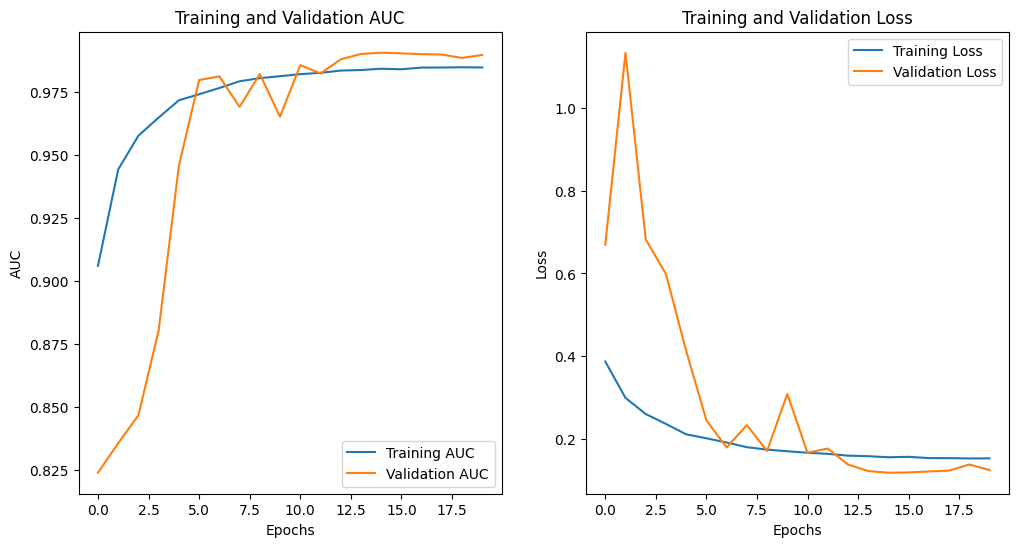

1621/1621 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step


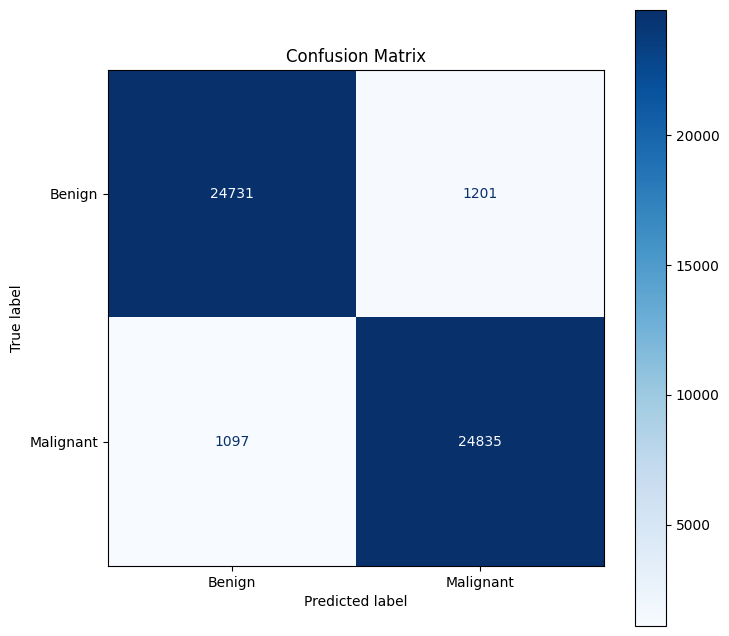

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.95      0.96     25932
   Malignant       0.95      0.96      0.96     25932

    accuracy                           0.96     51864
   macro avg       0.96      0.96      0.96     51864
weighted avg       0.96      0.96      0.96     51864



In [12]:
frozen_layers_25_imagenet_model = frozen_layers_25_imagenet()
train_and_perf_report(frozen_layers_25_imagenet_model, train_loader, valid_loader, learning_rate = 0.0001, cutoff=0.50)

Epoch 1/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 259s 36ms/step - auc: 0.8900 - loss: 0.4099 - val_auc: 0.8375 - val_loss: 0.9647 - learning_rate: 1.0000e-04
Epoch 2/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 220s 34ms/step - auc: 0.9550 - loss: 0.2681 - val_auc: 0.9522 - val_loss: 0.5601 - learning_rate: 1.0000e-04
Epoch 3/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 221s 34ms/step - auc: 0.9668 - loss: 0.2296 - val_auc: 0.9052 - val_loss: 0.4867 - learning_rate: 1.0000e-04
Epoch 4/30
6482/6483 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.9724 - loss: 0.2089
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 220s 34ms/step - auc: 0.9724 - loss: 0.2089 - val_auc: 0.9701 - val_loss: 0.2758 - learning_rate: 1.0000e-04
Epoch 5/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 220s 34ms/step - auc: 0.9779 - loss: 0.1857 - val_auc: 0.9350 - val_loss: 0.5014 - learning_rate: 5.0000e-05
Epoch 6/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 219s 34ms/step - auc: 0.9800 - loss: 0.1760 - val_auc:

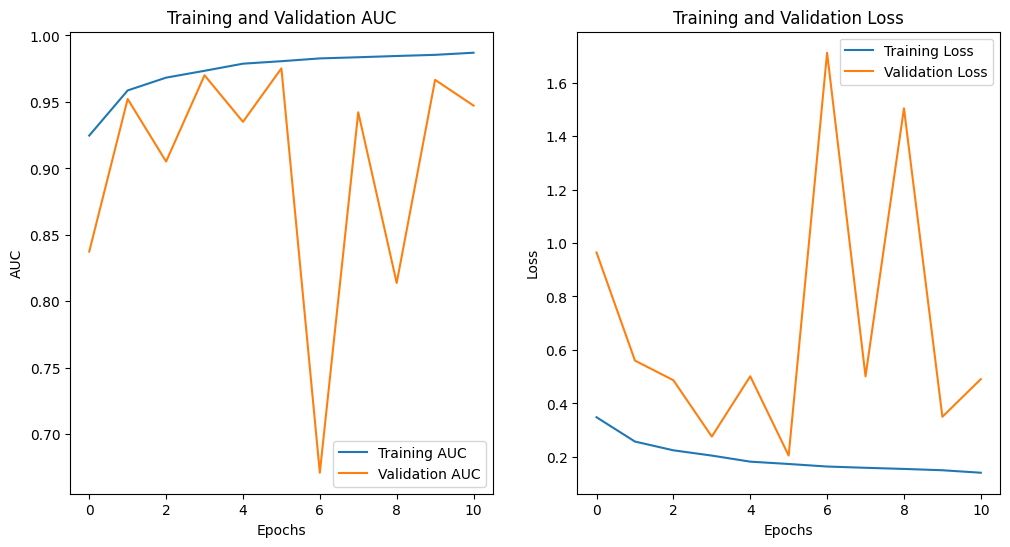

1621/1621 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step


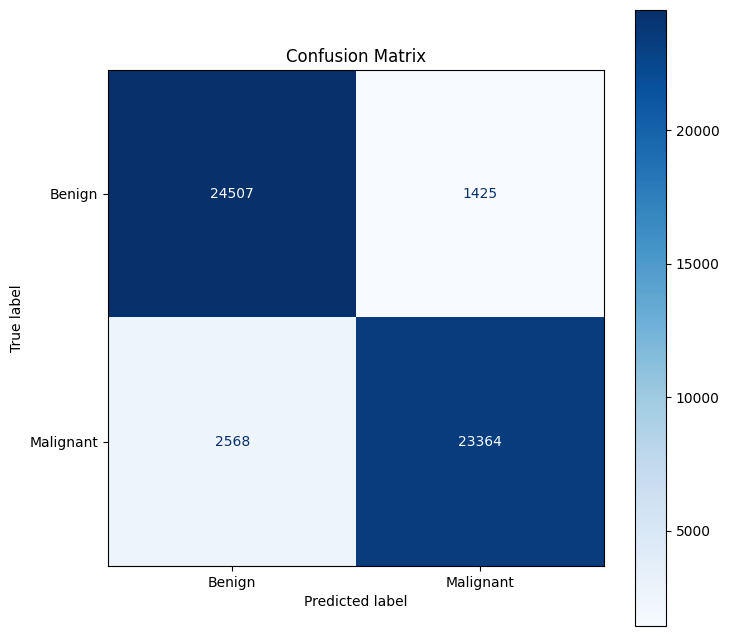

Classification Report:
              precision    recall  f1-score   support

      Benign       0.91      0.95      0.92     25932
   Malignant       0.94      0.90      0.92     25932

    accuracy                           0.92     51864
   macro avg       0.92      0.92      0.92     51864
weighted avg       0.92      0.92      0.92     51864



In [14]:
frozen_layers_13_imagenet_model = frozen_layers_13_imagenet()
train_and_perf_report(frozen_layers_13_imagenet_model, train_loader, valid_loader, learning_rate = 0.0001, cutoff=0.50)

Epoch 1/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 260s 37ms/step - auc: 0.8644 - loss: 0.4565 - val_auc: 0.9088 - val_loss: 0.3920 - learning_rate: 1.0000e-04
Epoch 2/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 230s 36ms/step - auc: 0.9250 - loss: 0.3478 - val_auc: 0.9215 - val_loss: 0.3884 - learning_rate: 1.0000e-04
Epoch 3/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 220s 34ms/step - auc: 0.9427 - loss: 0.3047 - val_auc: 0.9338 - val_loss: 0.3390 - learning_rate: 1.0000e-04
Epoch 4/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.9531 - loss: 0.2760
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 219s 34ms/step - auc: 0.9531 - loss: 0.2760 - val_auc: 0.9466 - val_loss: 0.3074 - learning_rate: 1.0000e-04
Epoch 5/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 220s 34ms/step - auc: 0.9630 - loss: 0.2448 - val_auc: 0.9704 - val_loss: 0.2301 - learning_rate: 5.0000e-05
Epoch 6/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 220s 34ms/step - auc: 0.9654 - loss: 0.2365 - val_auc:

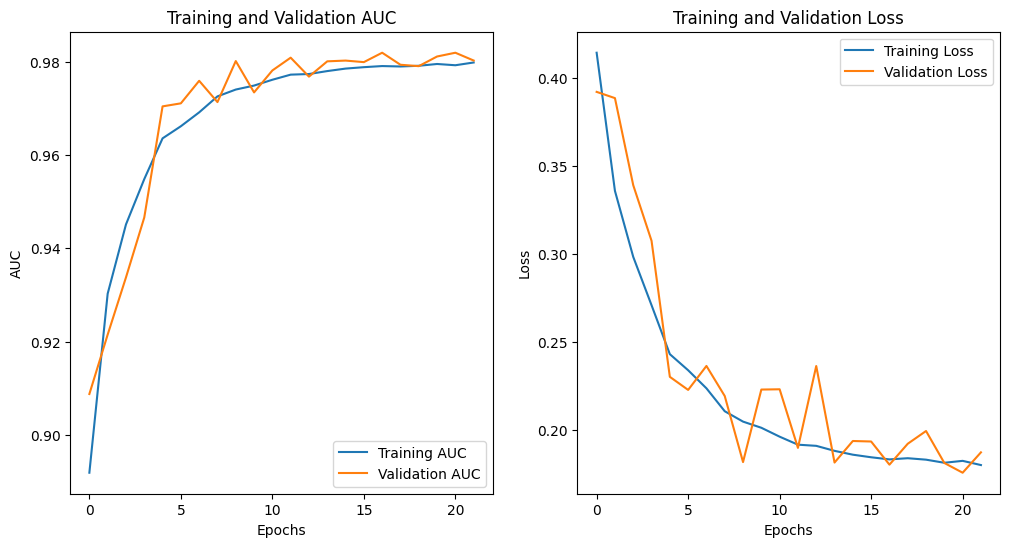

1621/1621 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step


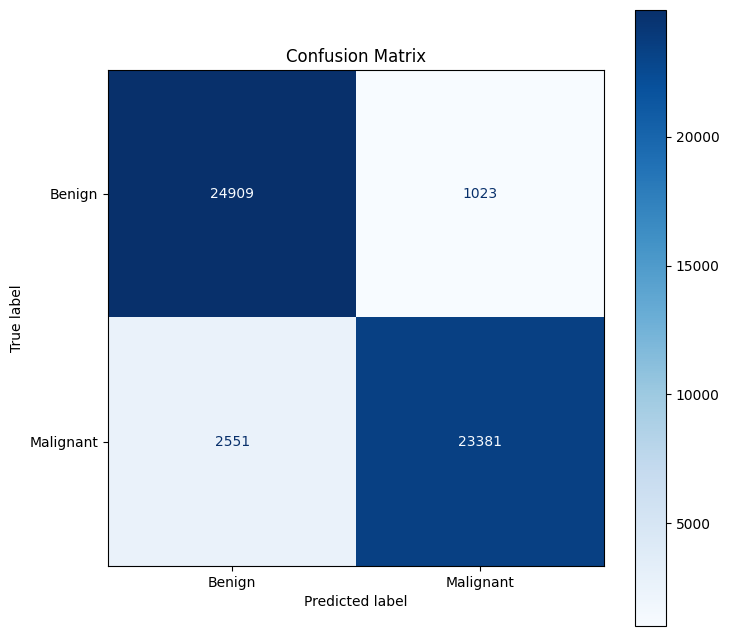

Classification Report:
              precision    recall  f1-score   support

      Benign       0.91      0.96      0.93     25932
   Malignant       0.96      0.90      0.93     25932

    accuracy                           0.93     51864
   macro avg       0.93      0.93      0.93     51864
weighted avg       0.93      0.93      0.93     51864



In [15]:
frozen_layers_37_imagenet_model = frozen_layers_37_imagenet()
train_and_perf_report(frozen_layers_37_imagenet_model, train_loader, valid_loader, learning_rate = 0.0001, cutoff=0.5)

Epoch 1/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 250s 35ms/step - auc: 0.8710 - loss: 0.4446 - val_auc: 0.8955 - val_loss: 0.7514 - learning_rate: 1.0000e-04
Epoch 2/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 215s 33ms/step - auc: 0.9412 - loss: 0.3082 - val_auc: 0.7074 - val_loss: 0.7317 - learning_rate: 1.0000e-04
Epoch 3/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 214s 33ms/step - auc: 0.9574 - loss: 0.2625 - val_auc: 0.9015 - val_loss: 0.6489 - learning_rate: 1.0000e-04
Epoch 4/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 214s 33ms/step - auc: 0.9646 - loss: 0.2381 - val_auc: 0.9264 - val_loss: 0.3943 - learning_rate: 1.0000e-04
Epoch 5/30
6482/6483 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.9701 - loss: 0.2189
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 218s 34ms/step - auc: 0.9701 - loss: 0.2189 - val_auc: 0.9065 - val_loss: 0.7322 - learning_rate: 1.0000e-04
Epoch 6/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 217s 33ms/step - auc: 0.9753 - loss: 0.1981 - val_auc:

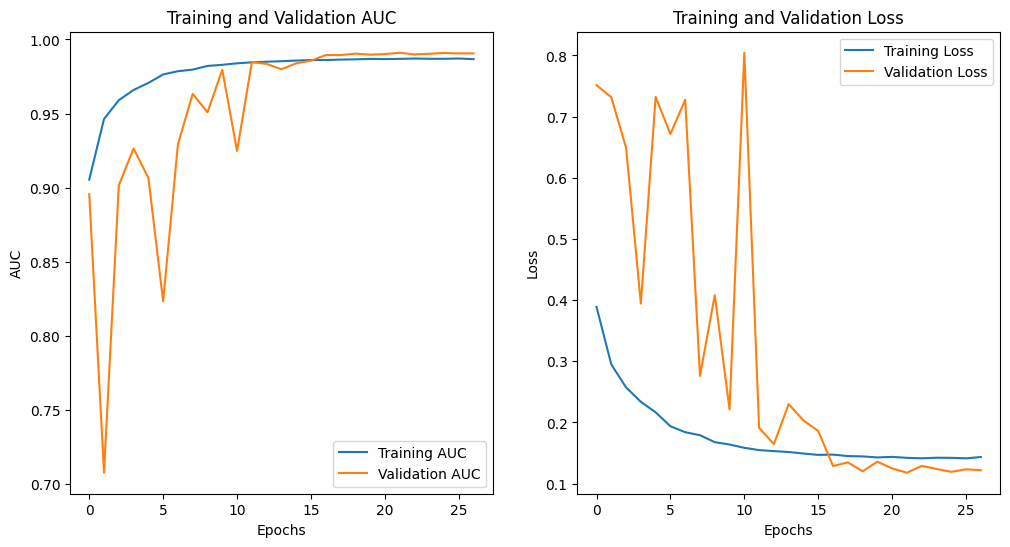

1621/1621 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step


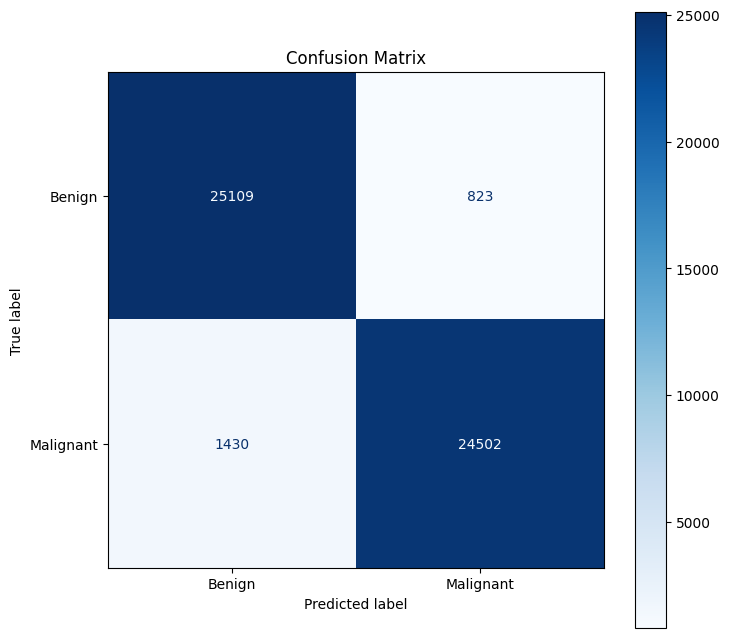

Classification Report:
              precision    recall  f1-score   support

      Benign       0.95      0.97      0.96     25932
   Malignant       0.97      0.94      0.96     25932

    accuracy                           0.96     51864
   macro avg       0.96      0.96      0.96     51864
weighted avg       0.96      0.96      0.96     51864



In [16]:
m_30 = frozen_layers_imagenet(frozen_layer=30)
train_and_perf_report(m_30, train_loader, valid_loader, learning_rate = 0.0001, cutoff=0.5)

Epoch 1/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 250s 35ms/step - auc: 0.8856 - loss: 0.4199 - val_auc: 0.9265 - val_loss: 0.7658 - learning_rate: 1.0000e-04
Epoch 2/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 215s 33ms/step - auc: 0.9506 - loss: 0.2821 - val_auc: 0.9731 - val_loss: 0.2099 - learning_rate: 1.0000e-04
Epoch 3/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 211s 33ms/step - auc: 0.9621 - loss: 0.2451 - val_auc: 0.9796 - val_loss: 0.2511 - learning_rate: 1.0000e-04
Epoch 4/30
6482/6483 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.9686 - loss: 0.2234
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 211s 33ms/step - auc: 0.9686 - loss: 0.2234 - val_auc: 0.9648 - val_loss: 0.3282 - learning_rate: 1.0000e-04
Epoch 5/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 211s 33ms/step - auc: 0.9748 - loss: 0.1993 - val_auc: 0.9798 - val_loss: 0.2281 - learning_rate: 5.0000e-05
Epoch 6/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 212s 33ms/step - auc: 0.9774 - loss: 0.1885 - val_auc:

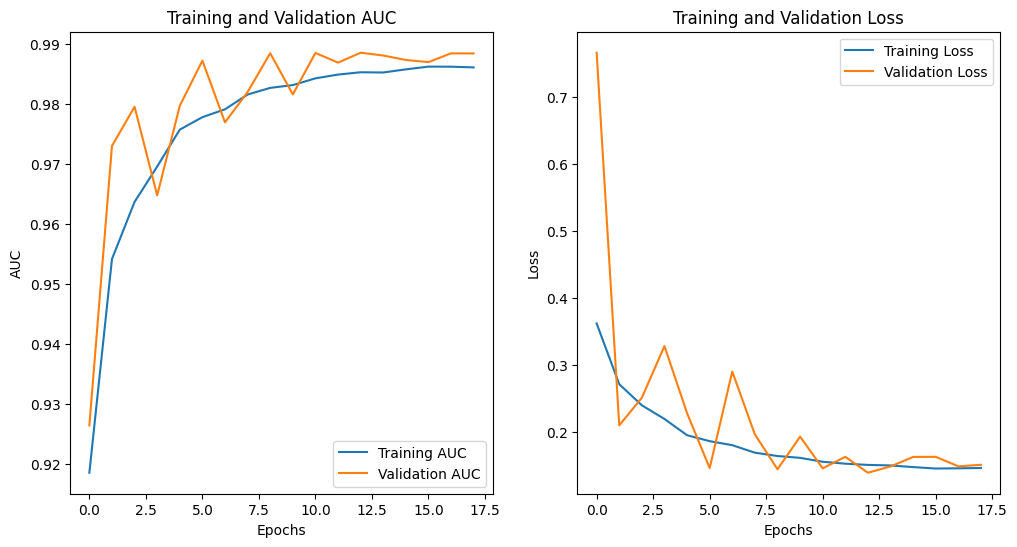

1621/1621 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step


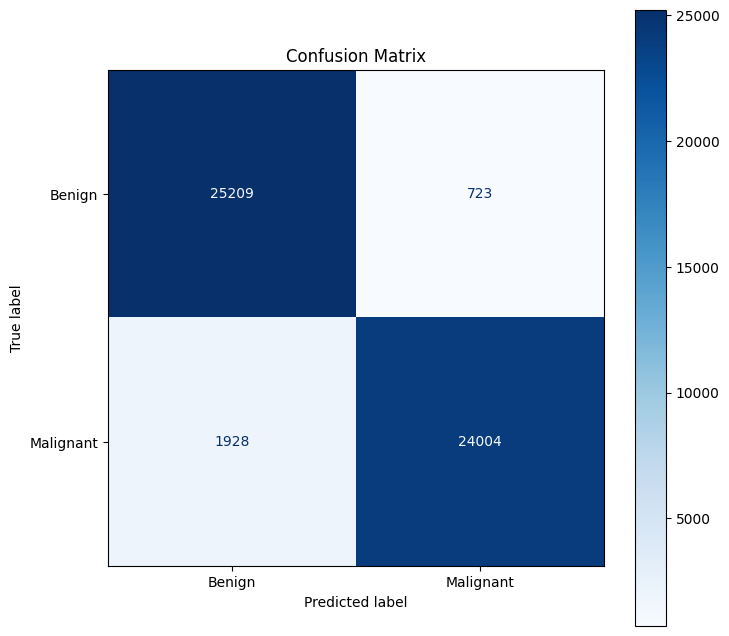

Classification Report:
              precision    recall  f1-score   support

      Benign       0.93      0.97      0.95     25932
   Malignant       0.97      0.93      0.95     25932

    accuracy                           0.95     51864
   macro avg       0.95      0.95      0.95     51864
weighted avg       0.95      0.95      0.95     51864



In [13]:
m_20 = frozen_layers_imagenet(frozen_layer=20)
train_and_perf_report(m_20, train_loader, valid_loader, learning_rate = 0.0001, cutoff=0.5)

#### Model Layer Results
Amazing, so we can see the 25 first layers of imagenet have a lot of primitive features that works well with our data.

The features available in the 37 layer model may be not abstract enough, and none of them are a good match for the features we have in our data set. That is, the layers in the 37 are too 'advanced'.

| Model | AUC | 
|----------|------------|
| 6   | 0.94      |
| 13   | 0.92    |
| 20   | 0.95 |
| 25   | 0.96    |
| 30   | 0.96 |
| 37   | 0.93    |

### Other Experiments we Could run

1. Threshold Optimization
2. Remove Dropout
3. Don't Translate Images

Some things that occured to me is that the threshold we use may not be the best one. We usually say 0.5 but what if we could get better results by changing this value? One way we could see this happen is if there are a lot training observations near the threshold.

Another is removing the last dropout of our 25 layer imagenet model. The original imagenet already was pretty good at regularization and not overfitting results. Do we really need another layer of complexity?

Finally, what about image translation. That *usually* helps with CNN image tasks. But a careful reading of the Kaggle competition description reveals a surprise about labeled data!!


#### Optimal Thhreshold

Does 0.50 really represent a treshold, or can we get an edge by moving the threshold to somewhere else.

First, we get the precsion, recall, and tresholds with sklearn's utility. Then we calculate all the f1 scores for each prediction. Then, we find the highest f1 score, and hence it's threshold. 


In [15]:
from sklearn.metrics import precision_recall_curve

y_true = valid_loader.labels  # True labels from validation generator

# Assuming `frozen_layers_13_imagenet_model` is your trained model and X_val is your validation dataset
y_pred_probs = frozen_layers_25_imagenet_model.predict(valid_loader)  # Probabilities for the positive class

precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probs)

import numpy as np

# Avoid division by zero
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")



1621/1621 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step
Optimal Threshold: 0.516875147819519


The threshold result indicates that there are some values clustered near 0.30, which is pretty far away from the expected 0.50. This may mean there are not a lot of contested observations, soo i'm not very confident that this enhancement will help


#### Remove Dropout

Maybe let's also get rid of the dropout from the last layer of our 25 layer imagenet

In [16]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

def frozen_layers_25_imagenet_no_do(**kwargs):
    # Load the EfficientNetB0 base model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
    
    # Freeze the first 100 layers
    for layer in base_model.layers[:25]:
        layer.trainable = False
    
    # Unfreeze the remaining layers
    for layer in base_model.layers[25:]:
        layer.trainable = True
    
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    # x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    # Combine the base model with the classification head
    model = Model(inputs=base_model.input, outputs=output)
    
    # Compile the model with a low learning rate for fine-tuning
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model
    # history = model.fit(train_generator, validation_data=val_generator, epochs=10)
    # return model, history
    return model

##### No Dropout, Weird Cutoff

Epoch 1/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 254s 36ms/step - auc: 0.8866 - loss: 0.4194 - val_auc: 0.9114 - val_loss: 0.4419 - learning_rate: 1.0000e-04
Epoch 2/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 219s 34ms/step - auc: 0.9439 - loss: 0.3005 - val_auc: 0.9591 - val_loss: 0.2631 - learning_rate: 1.0000e-04
Epoch 3/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 218s 34ms/step - auc: 0.9582 - loss: 0.2591 - val_auc: 0.9188 - val_loss: 0.3962 - learning_rate: 1.0000e-04
Epoch 4/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 220s 34ms/step - auc: 0.9665 - loss: 0.2318 - val_auc: 0.9056 - val_loss: 0.4254 - learning_rate: 1.0000e-04
Epoch 5/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 217s 33ms/step - auc: 0.9714 - loss: 0.2136 - val_auc: 0.8849 - val_loss: 0.5078 - learning_rate: 1.0000e-04
Epoch 6/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 218s 34ms/step - auc: 0.9737 - loss: 0.2042 - val_auc: 0.8458 - val_loss: 1.2287 - learning_rate: 1.0000e-04
Epoch 7/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 219s 34ms/step - auc: 0.9772 - loss: 0.1903 - val_au

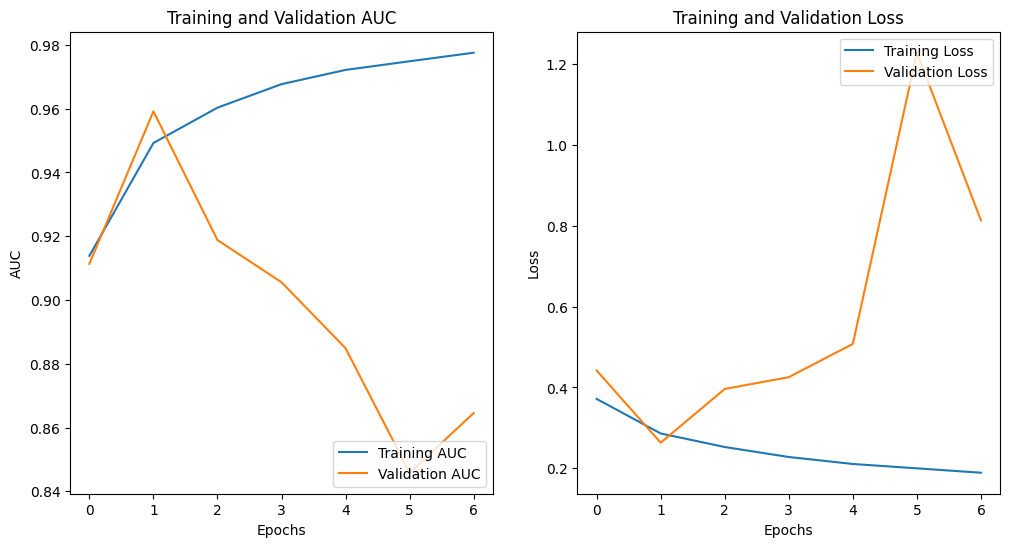

1621/1621 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step


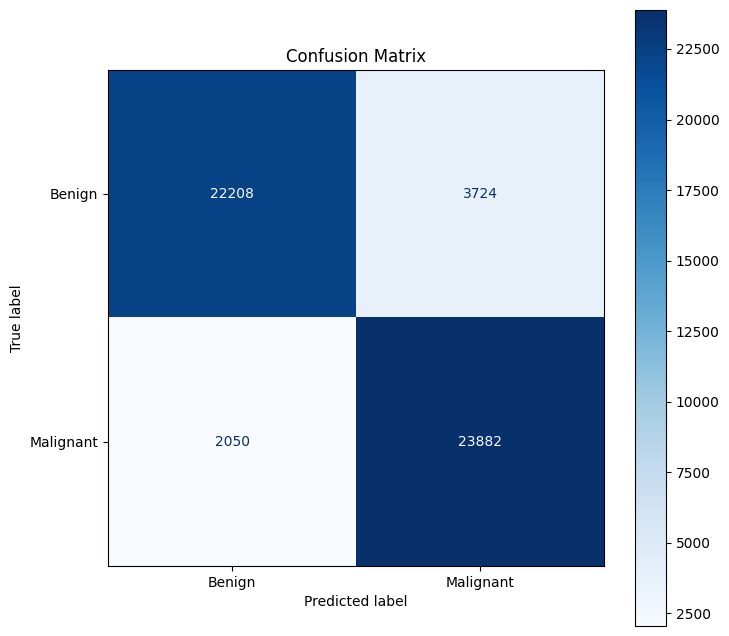

Classification Report:
              precision    recall  f1-score   support

      Benign       0.92      0.86      0.88     25932
   Malignant       0.87      0.92      0.89     25932

    accuracy                           0.89     51864
   macro avg       0.89      0.89      0.89     51864
weighted avg       0.89      0.89      0.89     51864



In [17]:
frozen_layers_25_imagenet_model_do = frozen_layers_25_imagenet_no_do()
# frozen_layers_13_imagenet_model.summary()
train_and_perf_report(frozen_layers_25_imagenet_model_do, train_loader, valid_loader, learning_rate = 0.0001, cutoff=0.306548535823822)


##### No Dropout, no weird Cutoff

Epoch 1/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 257s 36ms/step - auc: 0.8839 - loss: 0.4225 - val_auc: 0.9056 - val_loss: 0.4135 - learning_rate: 1.0000e-04
Epoch 2/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 216s 33ms/step - auc: 0.9453 - loss: 0.2971 - val_auc: 0.8643 - val_loss: 0.4891 - learning_rate: 1.0000e-04
Epoch 3/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 218s 34ms/step - auc: 0.9587 - loss: 0.2582 - val_auc: 0.8944 - val_loss: 0.7147 - learning_rate: 1.0000e-04
Epoch 4/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 218s 34ms/step - auc: 0.9663 - loss: 0.2321 - val_auc: 0.9115 - val_loss: 0.4542 - learning_rate: 1.0000e-04
Epoch 5/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 219s 34ms/step - auc: 0.9717 - loss: 0.2130 - val_auc: 0.7203 - val_loss: 0.9156 - learning_rate: 1.0000e-04
Epoch 6/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 219s 34ms/step - auc: 0.9746 - loss: 0.2012 - val_auc: 0.7087 - val_loss: 1.9608 - learning_rate: 1.0000e-04
Epoch 7/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 218s 34ms/step - auc: 0.9769 - loss: 0.1911 - val_au

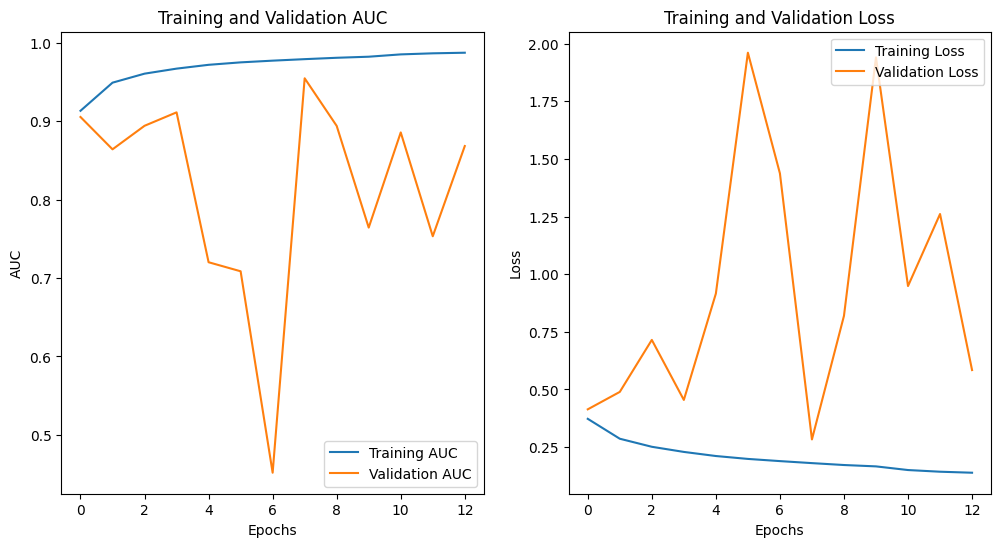

1621/1621 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step


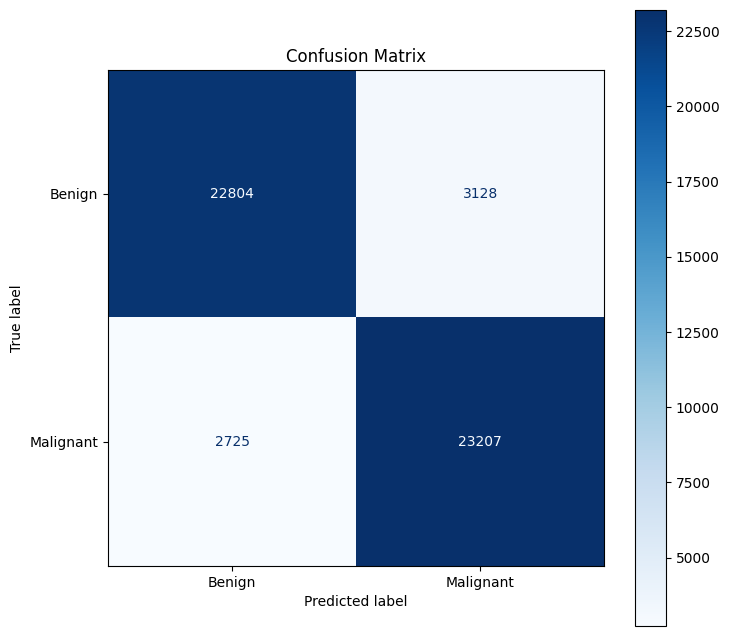

Classification Report:
              precision    recall  f1-score   support

      Benign       0.89      0.88      0.89     25932
   Malignant       0.88      0.89      0.89     25932

    accuracy                           0.89     51864
   macro avg       0.89      0.89      0.89     51864
weighted avg       0.89      0.89      0.89     51864



In [18]:
frozen_layers_25_imagenet_model_do = frozen_layers_25_imagenet_no_do()
train_and_perf_report(frozen_layers_25_imagenet_model_do, train_loader, valid_loader, learning_rate = 0.0001, cutoff=0.5)

##### Dropout, Weird cutoff

Epoch 1/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 259s 37ms/step - auc: 0.8729 - loss: 0.4415 - val_auc: 0.5143 - val_loss: 1.5790 - learning_rate: 1.0000e-04
Epoch 2/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 212s 33ms/step - auc: 0.9413 - loss: 0.3081 - val_auc: 0.9033 - val_loss: 0.4476 - learning_rate: 1.0000e-04
Epoch 3/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 208s 32ms/step - auc: 0.9570 - loss: 0.2638 - val_auc: 0.7170 - val_loss: 0.9683 - learning_rate: 1.0000e-04
Epoch 4/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.9650 - loss: 0.2371
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 209s 32ms/step - auc: 0.9650 - loss: 0.2371 - val_auc: 0.9452 - val_loss: 0.3333 - learning_rate: 1.0000e-04
Epoch 5/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 209s 32ms/step - auc: 0.9715 - loss: 0.2132 - val_auc: 0.9335 - val_loss: 0.5329 - learning_rate: 5.0000e-05
Epoch 6/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 209s 32ms/step - auc: 0.9753 - loss: 0.1984 - val_auc:

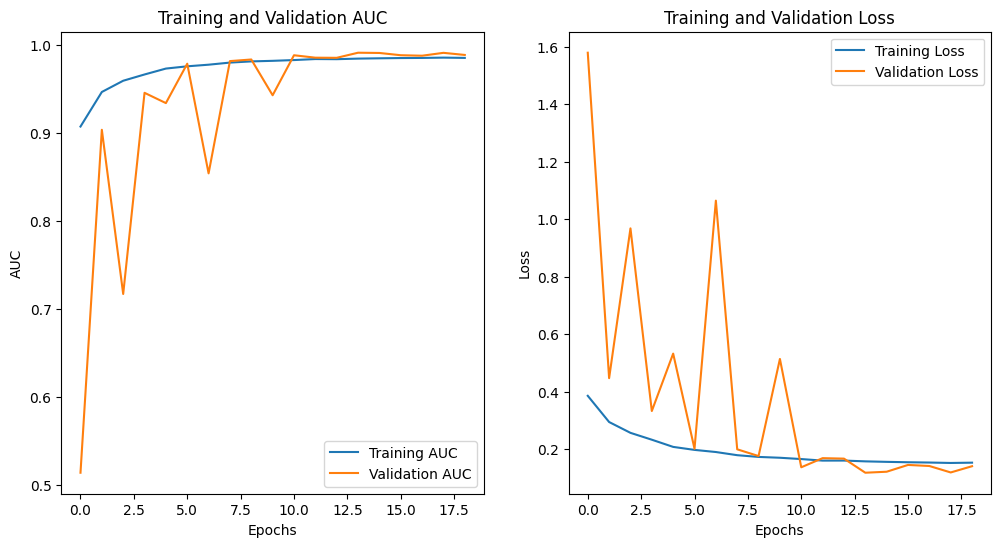

1621/1621 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step


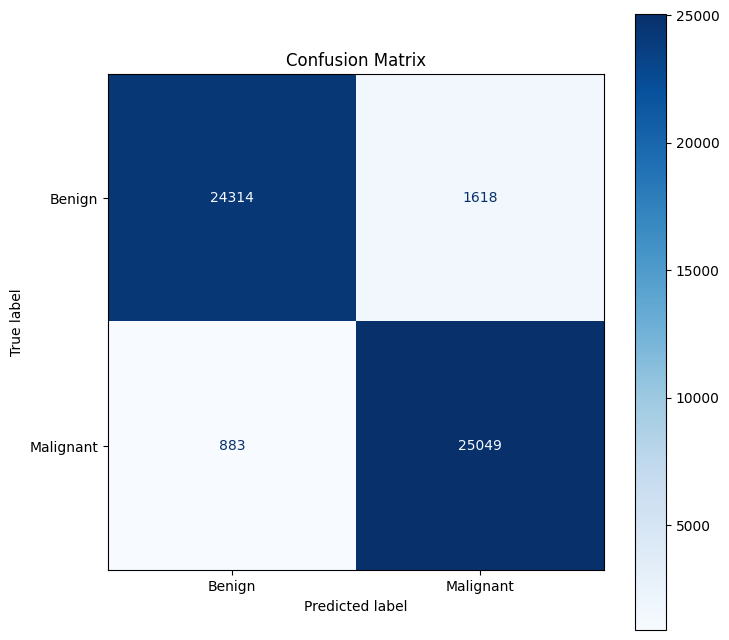

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.94      0.95     25932
   Malignant       0.94      0.97      0.95     25932

    accuracy                           0.95     51864
   macro avg       0.95      0.95      0.95     51864
weighted avg       0.95      0.95      0.95     51864



In [19]:
frozen_layers_25_imagenet_model = frozen_layers_25_imagenet()
train_and_perf_report(frozen_layers_25_imagenet_model, train_loader, valid_loader, learning_rate = 0.0001, cutoff=0.306548535823822)

the dropout layer is critical to the operation of the net since this means there is overfitting happening at the end of imagnet. we could also see this as the validation auc scores often exceeded or were at near same levels as the actual auc scores. 

Given the consistency of results between one feature being on and the other off, it could be that these two parameters are both working as regularization.

However, given just the cutoff value with a dropout, it seems like an imprecise weapon in an arsenal.

#### Don't Translate Images: Data Synthesis - Bad Idea?

Does it really help to have so many transformations to synthesize data? A careful reading of the Kaggle page shows us

    A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. 

So this may mean that the only part of the image in relation to the label, is the center of the image, not any cancer image outside of the center. In fact, they mention the outter patches to be useful for only CNN that do not use zero-padding.

Let's take the image-translation data synthesis techniques out and re-try training on the 25 layer imagenet model since it was the most performant so far.

Found 207452 validated image filenames belonging to 2 classes.
Found 51864 validated image filenames belonging to 2 classes.


I0000 00:00:1737791802.565901   81758 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10172 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/30


/home/user/School/boulder/intro_to_deep_learning/week3/.env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1737791813.587922   82754 service.cc:148] XLA service 0x790640012f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737791813.597474   82754 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-01-24 23:56:54.016401: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737791815.635038   82754 cuda_dnn.cc:529] Loaded cuDNN version 90300
2

   8/6483 ━━━━━━━━━━━━━━━━━━━━ 1:52 17ms/step - auc: 0.4665 - loss: 0.7476 

I0000 00:00:1737791829.342996   82754 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5189/6483 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - auc: 0.8897 - loss: 0.4098

2025-01-24 23:58:18.985487: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18585', 16 bytes spill stores, 16 bytes spill loads

2025-01-24 23:58:19.045311: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18585_0', 344 bytes spill stores, 520 bytes spill loads

2025-01-24 23:58:19.060959: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20412', 24 bytes spill stores, 24 bytes spill loads

2025-01-24 23:58:19.166751: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20412', 32 bytes spill stores, 32 bytes spill loads

2025-01-24 23:58:19.201524: I external/local_xla/xla

6481/6483 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8981 - loss: 0.3944

2025-01-24 23:59:03.854647: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2060', 16 bytes spill stores, 16 bytes spill loads

2025-01-24 23:59:03.922447: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2060_0', 344 bytes spill stores, 520 bytes spill loads

2025-01-24 23:59:04.023463: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2060', 104 bytes spill stores, 104 bytes spill loads



6483/6483 ━━━━━━━━━━━━━━━━━━━━ 143s 18ms/step - auc: 0.8981 - loss: 0.3944 - val_auc: 0.9219 - val_loss: 0.4518 - learning_rate: 1.0000e-04
Epoch 2/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 98s 15ms/step - auc: 0.9704 - loss: 0.2189 - val_auc: 0.8102 - val_loss: 0.9795 - learning_rate: 1.0000e-04
Epoch 3/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 98s 15ms/step - auc: 0.9842 - loss: 0.1585 - val_auc: 0.8917 - val_loss: 0.5233 - learning_rate: 1.0000e-04
Epoch 4/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 97s 15ms/step - auc: 0.9906 - loss: 0.1205 - val_auc: 0.9300 - val_loss: 0.4868 - learning_rate: 1.0000e-04
Epoch 5/30
6482/6483 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9941 - loss: 0.0939
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 97s 15ms/step - auc: 0.9941 - loss: 0.0939 - val_auc: 0.8796 - val_loss: 0.7370 - learning_rate: 1.0000e-04
Epoch 6/30
6483/6483 ━━━━━━━━━━━━━━━━━━━━ 97s 15ms/step - auc: 0.9971 - loss: 0.0634 - val_auc: 0.9246 - val_lo

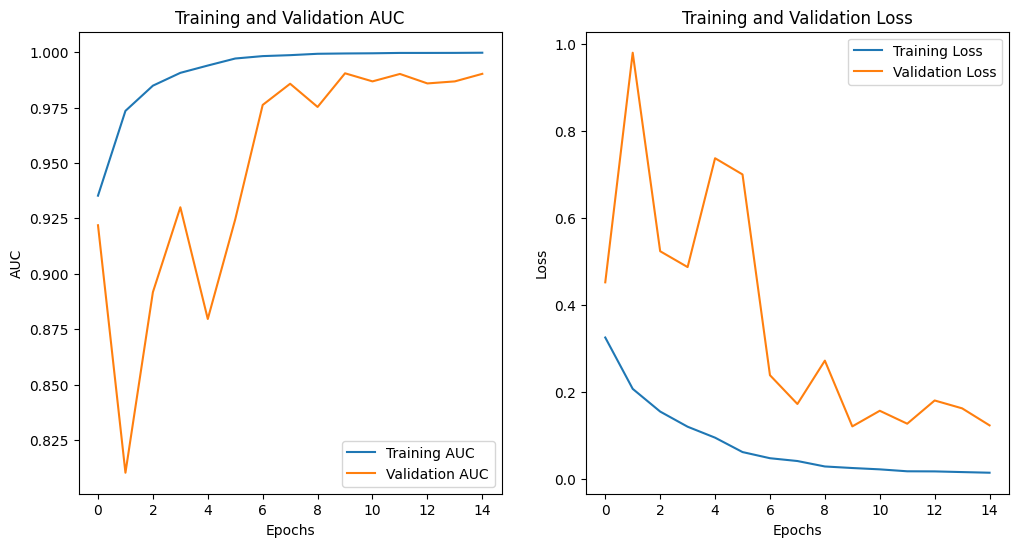

1621/1621 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step


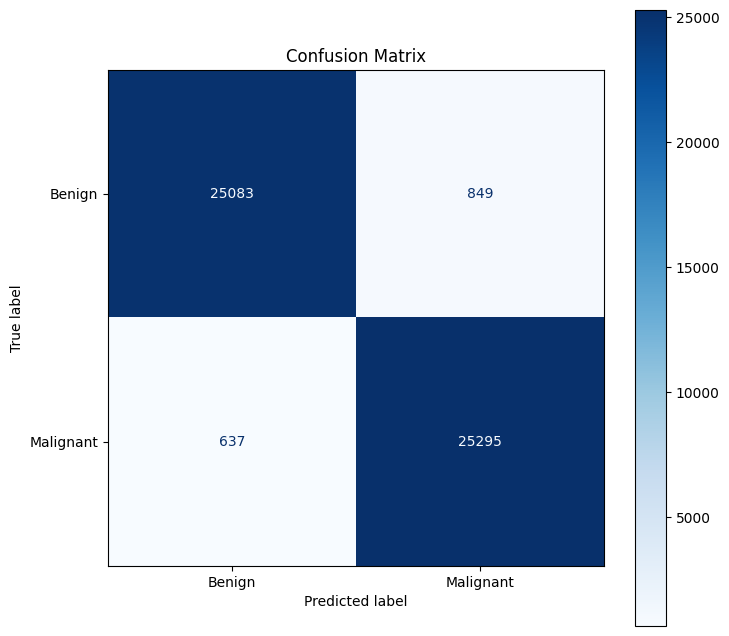

Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.97      0.97     25932
   Malignant       0.97      0.98      0.97     25932

    accuracy                           0.97     51864
   macro avg       0.97      0.97      0.97     51864
weighted avg       0.97      0.97      0.97     51864



In [13]:
# Set batch size
BATCH_SIZE = 32

# Combined data generator with augmentations
train_datagen = ImageDataGenerator(
    rescale=1/255,                # Normalize pixel values to [0, 1]
    # rotation_range=15,            # Rotate images by up to 15 degrees
    # width_shift_range=0.4,        # Horizontal shift (up to 40%)
    # height_shift_range=0.4,       # Vertical shift (up to 40%)
    # horizontal_flip=True,         # Flip images horizontally
    # zoom_range=0.2,               # Zoom in/out slightly
    # fill_mode='reflect'           # Fill mode to handle shifts (options: 'nearest', 'constant', 'reflect', 'wrap')
)

# Flow the entire training dataframe
train_loader = train_datagen.flow_from_dataframe(
    dataframe=train_df,           # Full training dataframe
    directory=train_images,       # Directory with images
    x_col='id',                   # Column with image filenames
    y_col='label',                # Column with labels (0 or 1)
    class_mode='binary',          # Binary classification
    target_size=(96, 96),         # Resize images to 96x96
    batch_size=BATCH_SIZE,        # Batch size
    shuffle=True                  # Shuffle images during training
)

# Validation data generator (no augmentations)
valid_datagen = ImageDataGenerator(rescale=1/255)

valid_loader = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,           # Validation dataframe
    directory=train_images,       # Directory with images
    x_col='id',
    y_col='label',
    class_mode='binary',
    target_size=(96, 96),
    batch_size=BATCH_SIZE,
    shuffle=False                 # No shuffling for validation
)

frozen_layers_25_imagenet_model = frozen_layers_25_imagenet()
train_and_perf_report(frozen_layers_25_imagenet_model, train_loader, valid_loader, learning_rate = 0.0001, cutoff=0.50)

Amazingly, this really helped! We get a result of 0.97, the highest score out of any model we tried so far! A different run had the final f1 score at 0.98. This model really shows potential when fed the right data.

## Conclusions

Reusing ImageNet architecture and weights has proven to be very promising. The lower levels retain enough of basic features that are useful for our data set. Later layers may not be so useful because they are looking for features that won't really exist in our data set.

Be wary of threshold optimization unless you are sure that there a lot of contested observations

Be mindful of which image transformations to use. Since we are not doing complex object detection or scene segmentation, we don't need to pull 'gotcha' questions on our poor ol' CNN while it trains.


In [22]:
import os
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define paths
test_dir = "data/test"  # Directory containing test images
model_path = "my_model.h5"  # Path to your trained model
output_csv_path = "submission.csv"  # Path for the output CSV

# Load the trained model
# model = load_model(model_path)
model = frozen_layers_25_imagenet_model
# Image size (ensure it matches your model's input size)
image_size = (96, 96)  # Replace with your model's required input size

# Preprocessing function for a single image
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)  # Load and resize image
    img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Get test image paths and IDs
test_files = os.listdir(test_dir)
test_df = pd.DataFrame({
    "id": [os.path.splitext(fname)[0] for fname in test_files],  # Extract file IDs (remove .tif)
    "file_path": [os.path.join(test_dir, fname) for fname in test_files]  # Full file paths
})

# Preprocess all test images
test_df["image_data"] = test_df["file_path"].apply(lambda x: preprocess_image(x, image_size))

# Convert image data into a 4D array (batch_size, height, width, channels)
image_data = np.stack(test_df["image_data"].to_list())

# Predict the test data
predictions = model.predict(image_data)

# Convert probabilities to binary labels (threshold = 0.5)
test_df["label"] = (predictions > 0.5).astype(int).flatten()

# Save predictions to CSV
submission_df = test_df[["id", "label"]]
submission_df.to_csv(output_csv_path, index=False)
print(f"Predictions saved to {output_csv_path}")


1786/1796 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2025-01-24 23:09:02.285432: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2031', 16 bytes spill stores, 16 bytes spill loads

2025-01-24 23:09:02.381859: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2031_0', 344 bytes spill stores, 520 bytes spill loads

2025-01-24 23:09:02.449965: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2031', 8 bytes spill stores, 8 bytes spill loads



1796/1796 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step
Predictions saved to submission.csv
